In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
m_sqrt_error = mean_squared_error
from scipy.optimize import minimize
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from matplotlib.pylab import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose

from tqdm import tqdm_notebook

from itertools import product
%matplotlib inline
data = pd.read_csv('UnemploymentRateJan1986-Dec2018.csv')

# data['Date'] = pd.to_datetime(data.Date)
# # data['year'] = pd.DatetimeIndex(data['Date']).year
# data.set_index('Date', inplace=True)
# new_data = data[['Adj Close']]

In [2]:

data['Months']=pd.to_datetime(data['Months'],format='%b-%y')
data.set_index('Months', inplace=True)
ts = data['Unemployment_Rates']

In [3]:
import tensorflow as tf
from tensorflow import keras

In [4]:
def split_in_batches(data, n_steps):
    return data.values.reshape(-1)[:(data.size//n_steps * n_steps)].reshape(-1, n_steps,1)

In [5]:
n_steps = 12
data3 = split_in_batches(ts, n_steps + 12)
data.shape

(396, 1)

In [92]:
X_size = data3.shape[0]
X_train_size = round(X_size * 0.8)
X_valid_size = round((X_size - X_train_size)/2)
X_test_size = X_size - X_train_size - X_valid_size
X_train, y_train = data3[:X_train_size, :n_steps], data3[:X_train_size, -12:, 0]
X_valid, y_valid = data3[X_train_size:X_train_size+X_valid_size, :n_steps], data3[X_train_size:X_train_size+X_valid_size, -12:, 0]
X_test, y_test = data3[X_train_size+X_valid_size:, :n_steps], data3[X_train_size+X_valid_size:, -12:, 0]
print('train:', X_train.shape, y_train.shape)
print('valid:', X_valid.shape, y_valid.shape)

print('test:', X_test.shape, y_test.shape)

train: (13, 12, 1) (13, 12)
valid: (2, 12, 1) (2, 12)
test: (1, 12, 1) (1, 12)


In [95]:
#baseline metrics
y_pred = np.repeat(X_valid[:,-1], 12, axis=1)#[:,:,np.newaxis]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.3097041666666669

In [127]:
model_simple_rnn = keras.models.Sequential([
  keras.layers.SimpleRNN(12, return_sequences=True, input_shape=[None, 1], activation='swish'),
  #keras.layers.SimpleRNN(12, return_sequences=True, input_shape=[None, 1], activation="tanh"),
  #keras.layers.SimpleRNN(12, return_sequences=True),
  keras.layers.SimpleRNN(12),
  #keras.layers.Dense(12, activation="tanh"),  
  #keras.layers.Dense(12, activation="sigmoid"),
  keras.layers.Dense(12)
])

In [128]:
model_simple_rnn.compile(loss=['mse', 'binary_crossentropy'], optimizer='adam', metrics=[['accuracy', 'mse']]) 

In [129]:
model_simple_rnn.summary() #text representation of the model

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_36 (SimpleRNN)    (None, None, 12)          168       
_________________________________________________________________
simple_rnn_37 (SimpleRNN)    (None, 12)                300       
_________________________________________________________________
dense_12 (Dense)             (None, 12)                156       
Total params: 624
Trainable params: 624
Non-trainable params: 0
_________________________________________________________________


In [130]:
%%timeit
model_simple_rnn.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size=12, epochs=200, verbose=0)

5.09 s ± 24.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [125]:
trainPredict = model_simple_rnn.predict(X_train)
testPredict = model_simple_rnn.predict(X_test)
predicted=np.concatenate((trainPredict, testPredict), axis=0)

In [126]:
trainScore = model_simple_rnn.evaluate(X_test, y_test, verbose=1)
print(trainScore)

1/1 [==============================] - 0s 720us/step - loss: 0.6904 - accuracy: 1.0000 - mse: 0.6904
[0.6904234886169434, 1.0, 0.6904234886169434]


In [102]:
model_simple_rnn.metrics_names

['loss', 'accuracy', 'mse']

In [103]:
def plot_training_history(history):
    plt.plot(history.history['val_loss'], 'r', label='Validation loss')
    plt.plot(history.history['loss'], 'b', label='Training loss')
    plt.legend()
plot_training_history(model_simple_rnn.history)


KeyError: 'val_loss'

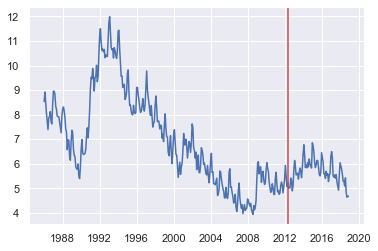

In [108]:
index = ts.index.values
plt.plot(index,ts)
#plt.plot(index,predicted)
plt.axvline(ts.index[316], c="r")
plt.show()

In [107]:
predicted

array([[ 8.755296 ,  8.954351 ,  8.519053 ,  8.296007 ,  8.25635  ,
         7.8486557,  7.7887144,  7.9670916,  8.0878935,  7.710256 ,
         7.5428567,  8.022088 ],
       [ 6.754116 ,  6.9847603,  6.767105 ,  6.3075504,  6.3689594,
         6.106265 ,  5.917404 ,  6.066894 ,  6.259881 ,  5.990321 ,
         5.7500806,  6.1031537],
       [10.126211 , 10.153984 ,  9.813366 ,  9.531788 ,  9.453271 ,
         9.110781 ,  9.029947 ,  9.164543 ,  9.423017 ,  8.821782 ,
         8.901616 ,  9.288106 ],
       [10.821845 , 10.8032255, 10.386277 , 10.1694145, 10.084783 ,
         9.744006 ,  9.612816 ,  9.778595 , 10.070318 ,  9.359135 ,
         9.545799 ,  9.892553 ],
       [ 9.668916 ,  9.930669 ,  9.428411 ,  9.242311 ,  8.981244 ,
         8.563191 ,  8.774553 ,  8.872331 ,  8.908999 ,  8.553249 ,
         8.4178505,  8.9754   ],
       [ 8.837265 ,  9.215592 ,  8.5466795,  8.488828 ,  8.279114 ,
         7.7965717,  7.940325 ,  8.1353445,  8.062704 ,  7.8169804,
         7.547504 ,

ValueError: x and y must have same first dimension, but have shapes (396,) and (1, 12)

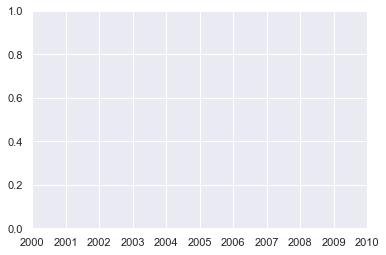

In [111]:
plt.plot(index, testPredict);

In [119]:
X_new, y_new = data3[:n_steps], data3[n_steps:]
X = X_new
for step_ahead in range(12):
    y_pred_one = model_simple_rnn.predict(X[:, step_ahead:])[:,np.newaxis]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, nsteps:]

ValueError: all the input array dimensions except for the concatenation axis must match exactly

In [120]:
y_pred_one

array([[[ 8.283346 ,  8.576004 ,  8.040685 ,  7.881403 ,  7.8312454,
          7.4188523,  7.3595695,  7.5616746,  7.6300344,  7.3275275,
          7.0805554,  7.578562 ]],

       [[ 6.5062613,  6.8746004,  6.4665747,  6.1277566,  6.140998 ,
          5.9702353,  5.7317643,  5.902934 ,  6.0922694,  5.8471985,
          5.5907507,  5.8972263]],

       [[10.666022 , 10.689794 , 10.277617 , 10.050827 ,  9.927716 ,
          9.576123 ,  9.521206 ,  9.662801 ,  9.91437  ,  9.264735 ,
          9.39837  ,  9.785905 ]],

       [[10.742337 , 10.751266 , 10.325245 , 10.10814  , 10.003334 ,
          9.6673   ,  9.566874 ,  9.720715 ,  9.998958 ,  9.314269 ,
          9.478989 ,  9.838145 ]],

       [[ 8.544765 ,  9.009179 ,  8.243348 ,  8.237547 ,  8.009214 ,
          7.544031 ,  7.691607 ,  7.896607 ,  7.7974267,  7.5997195,
          7.282199 ,  7.8747706]],

       [[ 7.992684 ,  8.3673935,  7.728261 ,  7.623964 ,  7.5874057,
          7.170512 ,  7.1029253,  7.3194532,  7.370268 ,  7.1

Another model

In [4]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
        # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i+target_size])
    return np.array(data), np.array(labels)

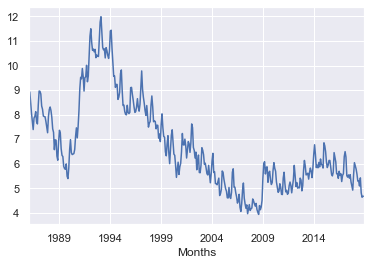

In [6]:
train=360
valid=24
test=12

ts.plot()

In [7]:
ts = ts.values

In [9]:
ts_mean = ts[:train].mean()
ts_std = ts[:train].std()

In [10]:
ts_data = (ts-ts_mean)/ts_std

In [114]:
ts_past_history = 12
ts_target = 0

x_train_uni, y_train_uni = univariate_data(ts_data, 0, train,
                                           ts_past_history,
                                           ts_target)
x_val_uni, y_val_uni = univariate_data(ts_data, train, None,
                                       ts_past_history,
                                       ts_target)

In [115]:
train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [117]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target to predict')
print (y_train_uni[0])

Single window of past history
[[0.91038818]
 [1.12122978]
 [0.88335721]
 [0.65629703]
 [0.46708021]
 [0.29408198]
 [0.54817313]
 [0.5860165 ]
 [0.6887342 ]
 [0.46708021]
 [0.41842446]
 [0.83470146]]

 Target to predict
1.1428545599187923


In [118]:
def create_time_steps(length):
    return list(range(-length, 0))

In [119]:
def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt

<module 'matplotlib.pyplot' from '/Users/jayjayabela/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

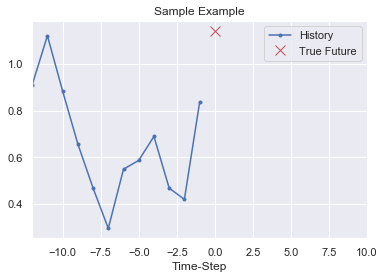

In [120]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

In [121]:
def baseline(history):
    return np.mean(history)

<module 'matplotlib.pyplot' from '/Users/jayjayabela/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

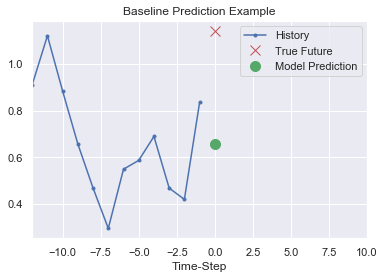

In [122]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Baseline Prediction Example')

In [123]:
model_simple_rnn = keras.models.Sequential([
   keras.layers.SimpleRNN(12, return_sequences=True, input_shape=[None, 1], activation='swish'),
#   keras.layers.SimpleRNN(12, return_sequences=True, input_shape=[None, 1], activation="tanh"),
  #keras.layers.SimpleRNN(12, return_sequences=True),
#   keras.layers.SimpleRNN(12),
  #keras.layers.Dense(12, activation="tanh"),  
  keras.layers.Dense(12, input_dim=12, activation="swish"),
  keras.layers.Dense(1)
])

In [124]:
model_simple_rnn.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_11 (SimpleRNN)    (None, None, 12)          168       
_________________________________________________________________
dense_20 (Dense)             (None, None, 12)          156       
_________________________________________________________________
dense_21 (Dense)             (None, None, 1)           13        
Total params: 337
Trainable params: 337
Non-trainable params: 0
_________________________________________________________________


In [125]:
model_simple_rnn.compile(loss=['mse', 'binary_crossentropy'], optimizer='adam', metrics=[['accuracy', 'mse']]) 

In [126]:
%%timeit
model_simple_rnn.fit(x_train_uni, y_train_uni,  batch_size=12, epochs=200, verbose=0)

7.92 s ± 61.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [127]:
BATCH_SIZE = 360
BUFFER_SIZE = 24

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [128]:
for x, y in val_univariate.take(1):
    print(model_simple_rnn.predict(x).shape)

(24, 12, 1)


In [129]:
model_simple_rnn.fit(train_univariate, epochs=200,
                      steps_per_epoch=12,
                      validation_data=val_univariate, validation_steps=12, verbose=0)

ValueError: x and y must have same first dimension, but have shapes (1,) and (12, 1)

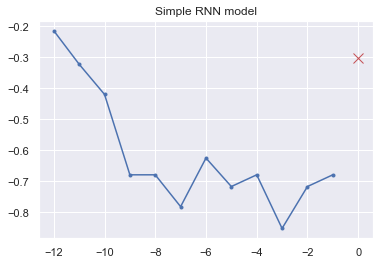

In [130]:
for x, y in val_univariate.take(1):
    plot = show_plot([x[0].numpy(), y[0].numpy(), model_simple_rnn.predict(x)[0]], 0, 'Simple RNN model')
    plot.show()

In [131]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(12, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(12),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

In [132]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

(24, 1)


In [133]:
simple_lstm_model.fit(train_univariate, epochs=200,
                      steps_per_epoch=24,
                      validation_data=val_univariate, validation_steps=50, verbose=0)

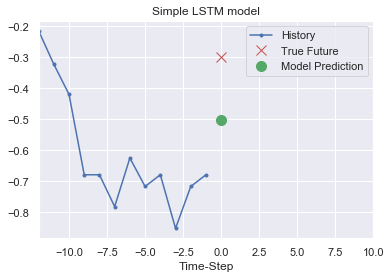

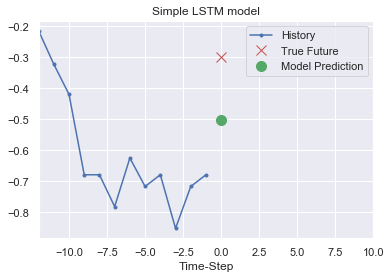

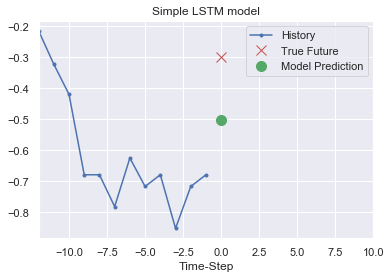

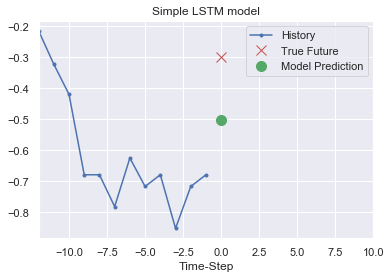

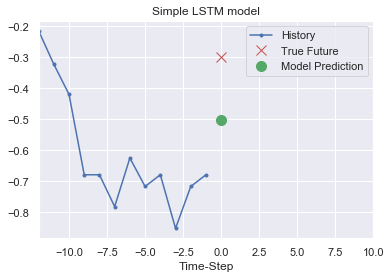

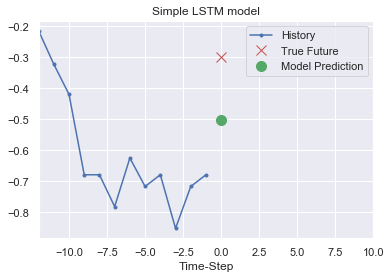

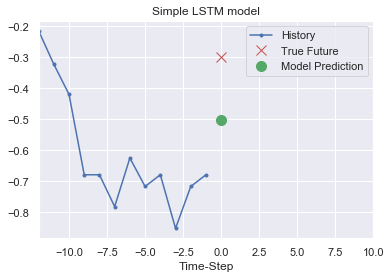

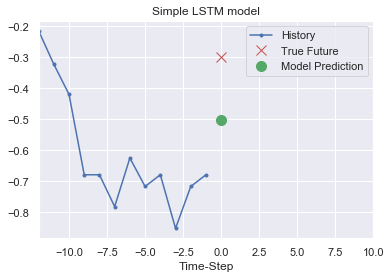

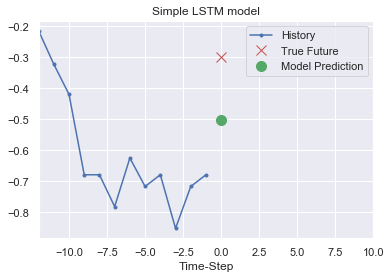

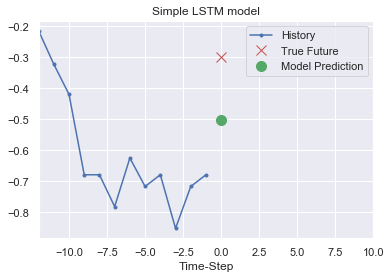

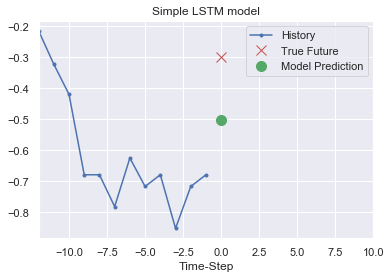

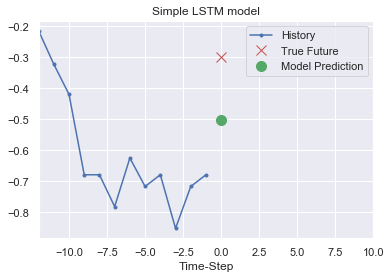

In [134]:
for x, y in val_univariate.take(12):
    plot = show_plot([x[0].numpy(), y[0].numpy(), simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
    plot.show()

In [43]:
ts

array([ 8.53,  8.92,  8.48,  8.06,  7.71,  7.39,  7.86,  7.93,  8.12,
        7.71,  7.62,  8.39,  8.96,  8.95,  8.84,  8.35,  8.22,  7.94,
        7.92,  7.91,  7.72,  7.48,  7.26,  7.92,  8.21,  8.31,  8.16,
        7.88,  7.42,  7.28,  6.57,  6.97,  6.96,  6.31,  6.14,  6.9 ,
        7.36,  7.25,  6.61,  6.34,  6.29,  5.89,  5.8 ,  5.77,  5.99,
        5.49,  5.39,  5.83,  6.57,  6.98,  6.45,  6.37,  6.39,  6.41,
        6.58,  7.11,  7.46,  7.05,  7.51,  8.16,  9.05,  9.52,  9.46,
        9.88,  9.55,  8.96,  9.51,  9.54, 10.01,  9.34,  9.57, 10.44,
       11.2 , 11.5 , 10.95, 10.62, 10.67, 10.56, 10.66, 10.32, 10.43,
       10.38, 10.37, 11.09, 11.77, 11.99, 11.36, 10.74, 10.64, 10.68,
       10.31, 10.73, 10.61, 10.41, 10.29, 10.59, 11.41, 11.44, 10.7 ,
       10.15,  9.56,  9.58,  9.11,  9.23,  9.23,  8.62,  8.71,  8.91,
        9.67,  9.82,  8.99,  8.37,  8.39,  8.13,  8.01,  7.99,  8.38,
        8.09,  8.04,  8.09,  9.1 ,  9.11,  8.83,  8.59,  8.31,  8.09,
        8.13,  8.33,

In [44]:
time_window = 12
Xall, Yall = [], []
Xall_not_scaled, Yall_not_scaled = [], []
for i in range(time_window, len(ts)):
    Xall.append(ts[i-time_window:i, 0])
    Xall_not_scaled.append(ts[i- time_window:i, 0])
    Yall.append(ts[i, 0])
    Yall_not_scaled.append(ts[i, 0])
train=360
valid=24
test=12  
    
Xall = np.array(Xall) # Convert them from list to array
Yall = np.array(Yall)
Xall_not_scaled = np.array(Xall_not_scaled)
Yall_not_scaled = np.array(Yall_not_scaled)
train_size = 360
test_size = 12
Xtrain = Xall[:train_size, :]
Ytrain = Yall[:train_size]
Xtest = Xall[-test_size:, :] 
Ytest = Yall[-test_size:]

IndexError: too many indices for array

Log transformation

In [112]:
ts_log = np.log(ts)

In [135]:
x_train_uni2, y_train_uni2 = univariate_data(ts_log, 0, train,
                                           ts_past_history,
                                           ts_target)
x_val_uni2, y_val_uni2 = univariate_data(ts_log, train, None,
                                       ts_past_history,
                                       ts_target)

In [136]:
train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni2, y_train_uni2))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni2, y_val_uni2))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

<module 'matplotlib.pyplot' from '/Users/jayjayabela/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

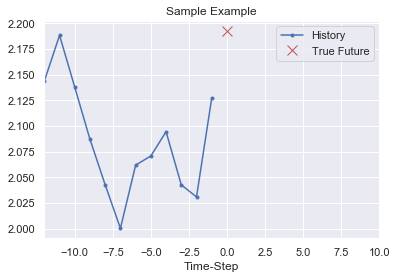

In [137]:
show_plot([x_train_uni2[0], y_train_uni2[0]], 0, 'Sample Example')

In [138]:
model_simple_rnn = keras.models.Sequential([
   keras.layers.SimpleRNN(12, return_sequences=True, input_shape=[None, 1], activation='swish'),
#   keras.layers.SimpleRNN(12, return_sequences=True, input_shape=[None, 1], activation="tanh"),
  #keras.layers.SimpleRNN(12, return_sequences=True),
#   keras.layers.SimpleRNN(12),
  #keras.layers.Dense(12, activation="tanh"),  
  keras.layers.Dense(12, input_dim=12, activation="swish"),
  keras.layers.Dense(1)
])

In [139]:
model_simple_rnn.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_12 (SimpleRNN)    (None, None, 12)          168       
_________________________________________________________________
dense_24 (Dense)             (None, None, 12)          156       
_________________________________________________________________
dense_25 (Dense)             (None, None, 1)           13        
Total params: 337
Trainable params: 337
Non-trainable params: 0
_________________________________________________________________


In [140]:
model_simple_rnn.compile(loss=['mse', 'binary_crossentropy'], optimizer='adam', metrics=[['accuracy', 'mse']]) 

In [141]:
%%timeit
model_simple_rnn.fit(x_train_uni2, y_train_uni2,  batch_size=12, epochs=200, verbose=0)

8.19 s ± 339 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [146]:
BATCH_SIZE = 360
BUFFER_SIZE = 24

train_univariate2 = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate2 = train_univariate2.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate2 = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate2 = val_univariate2.batch(BATCH_SIZE).repeat()

In [147]:
for x, y in val_univariate2.take(1):
    print(model_simple_rnn.predict(x).shape)

(24, 12, 1)


In [149]:
model_simple_rnn.fit(train_univariate2, epochs=200,
                      steps_per_epoch=12,
                      validation_data=val_univariate2, validation_steps=12)

Epoch 1/200
12/12 [==============================] - 0s 5ms/step - loss: 0.1511 - accuracy: 0.0000e+00 - mse: 0.1511 - val_loss: 0.0769 - val_accuracy: 0.0000e+00 - val_mse: 0.0769
Epoch 2/200
12/12 [==============================] - 0s 7ms/step - loss: 0.1510 - accuracy: 0.0000e+00 - mse: 0.1510 - val_loss: 0.0769 - val_accuracy: 0.0000e+00 - val_mse: 0.0769
Epoch 3/200
12/12 [==============================] - 0s 5ms/step - loss: 0.1509 - accuracy: 0.0000e+00 - mse: 0.1509 - val_loss: 0.0769 - val_accuracy: 0.0000e+00 - val_mse: 0.0769
Epoch 4/200
12/12 [==============================] - 0s 5ms/step - loss: 0.1509 - accuracy: 0.0000e+00 - mse: 0.1509 - val_loss: 0.0769 - val_accuracy: 0.0000e+00 - val_mse: 0.0769
Epoch 5/200
12/12 [==============================] - 0s 5ms/step - loss: 0.1508 - accuracy: 0.0000e+00 - mse: 0.1508 - val_loss: 0.0769 - val_accuracy: 0.0000e+00 - val_mse: 0.0769
Epoch 6/200
12/12 [==============================] - 0s 5ms/step - loss: 0.1508 - accuracy: 0.0

12/12 [==============================] - 0s 4ms/step - loss: 0.1484 - accuracy: 0.0000e+00 - mse: 0.1484 - val_loss: 0.0761 - val_accuracy: 0.0000e+00 - val_mse: 0.0761
Epoch 47/200
12/12 [==============================] - 0s 4ms/step - loss: 0.1483 - accuracy: 0.0000e+00 - mse: 0.1483 - val_loss: 0.0760 - val_accuracy: 0.0000e+00 - val_mse: 0.0760
Epoch 48/200
12/12 [==============================] - 0s 5ms/step - loss: 0.1482 - accuracy: 0.0000e+00 - mse: 0.1482 - val_loss: 0.0760 - val_accuracy: 0.0000e+00 - val_mse: 0.0760
Epoch 49/200
12/12 [==============================] - 0s 4ms/step - loss: 0.1481 - accuracy: 0.0000e+00 - mse: 0.1481 - val_loss: 0.0759 - val_accuracy: 0.0000e+00 - val_mse: 0.0759
Epoch 50/200
12/12 [==============================] - 0s 4ms/step - loss: 0.1481 - accuracy: 0.0000e+00 - mse: 0.1481 - val_loss: 0.0758 - val_accuracy: 0.0000e+00 - val_mse: 0.0758
Epoch 51/200
12/12 [==============================] - 0s 4ms/step - loss: 0.1480 - accuracy: 0.0000e+00

12/12 [==============================] - 0s 4ms/step - loss: 0.1443 - accuracy: 0.0000e+00 - mse: 0.1443 - val_loss: 0.0709 - val_accuracy: 0.0000e+00 - val_mse: 0.0709
Epoch 92/200
12/12 [==============================] - 0s 4ms/step - loss: 0.1442 - accuracy: 0.0000e+00 - mse: 0.1442 - val_loss: 0.0708 - val_accuracy: 0.0000e+00 - val_mse: 0.0708
Epoch 93/200
12/12 [==============================] - 0s 4ms/step - loss: 0.1441 - accuracy: 0.0000e+00 - mse: 0.1441 - val_loss: 0.0706 - val_accuracy: 0.0000e+00 - val_mse: 0.0706
Epoch 94/200
12/12 [==============================] - 0s 4ms/step - loss: 0.1441 - accuracy: 0.0000e+00 - mse: 0.1441 - val_loss: 0.0705 - val_accuracy: 0.0000e+00 - val_mse: 0.0705
Epoch 95/200
12/12 [==============================] - 0s 4ms/step - loss: 0.1440 - accuracy: 0.0000e+00 - mse: 0.1440 - val_loss: 0.0704 - val_accuracy: 0.0000e+00 - val_mse: 0.0704
Epoch 96/200
12/12 [==============================] - 0s 4ms/step - loss: 0.1439 - accuracy: 0.0000e+00

Epoch 136/200
12/12 [==============================] - 0s 4ms/step - loss: 0.1405 - accuracy: 0.0000e+00 - mse: 0.1405 - val_loss: 0.0645 - val_accuracy: 0.0000e+00 - val_mse: 0.0645
Epoch 137/200
12/12 [==============================] - 0s 4ms/step - loss: 0.1404 - accuracy: 0.0000e+00 - mse: 0.1404 - val_loss: 0.0644 - val_accuracy: 0.0000e+00 - val_mse: 0.0644
Epoch 138/200
12/12 [==============================] - 0s 4ms/step - loss: 0.1403 - accuracy: 0.0000e+00 - mse: 0.1403 - val_loss: 0.0643 - val_accuracy: 0.0000e+00 - val_mse: 0.0643
Epoch 139/200
12/12 [==============================] - 0s 4ms/step - loss: 0.1403 - accuracy: 0.0000e+00 - mse: 0.1403 - val_loss: 0.0642 - val_accuracy: 0.0000e+00 - val_mse: 0.0642
Epoch 140/200
12/12 [==============================] - 0s 4ms/step - loss: 0.1402 - accuracy: 0.0000e+00 - mse: 0.1402 - val_loss: 0.0641 - val_accuracy: 0.0000e+00 - val_mse: 0.0641
Epoch 141/200
12/12 [==============================] - 0s 4ms/step - loss: 0.1401 - a

Epoch 181/200
12/12 [==============================] - 0s 5ms/step - loss: 0.1376 - accuracy: 0.0000e+00 - mse: 0.1376 - val_loss: 0.0615 - val_accuracy: 0.0000e+00 - val_mse: 0.0615
Epoch 182/200
12/12 [==============================] - 0s 5ms/step - loss: 0.1376 - accuracy: 0.0000e+00 - mse: 0.1376 - val_loss: 0.0614 - val_accuracy: 0.0000e+00 - val_mse: 0.0614
Epoch 183/200
12/12 [==============================] - 0s 6ms/step - loss: 0.1375 - accuracy: 0.0000e+00 - mse: 0.1375 - val_loss: 0.0614 - val_accuracy: 0.0000e+00 - val_mse: 0.0614
Epoch 184/200
12/12 [==============================] - 0s 5ms/step - loss: 0.1375 - accuracy: 0.0000e+00 - mse: 0.1375 - val_loss: 0.0613 - val_accuracy: 0.0000e+00 - val_mse: 0.0613
Epoch 185/200
12/12 [==============================] - 0s 7ms/step - loss: 0.1374 - accuracy: 0.0000e+00 - mse: 0.1374 - val_loss: 0.0613 - val_accuracy: 0.0000e+00 - val_mse: 0.0613
Epoch 186/200
12/12 [==============================] - 0s 5ms/step - loss: 0.1374 - a

ValueError: x and y must have same first dimension, but have shapes (1,) and (12, 1)

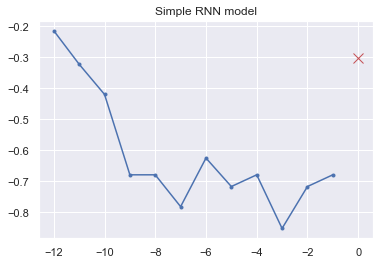

In [150]:
for x, y in val_univariate2.take(1):
    plot = show_plot([x[0].numpy(), y[0].numpy(), model_simple_rnn.predict(x)[0]], 0, 'Simple RNN model')
    plot.show()

In [151]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(12, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(12),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

In [152]:
for x, y in val_univariate2.take(1):
    print(simple_lstm_model.predict(x).shape)

(24, 1)


In [153]:
simple_lstm_model.fit(train_univariate2, epochs=200,
                      steps_per_epoch=24,
                      validation_data=val_univariate2, validation_steps=50, verbose=0)

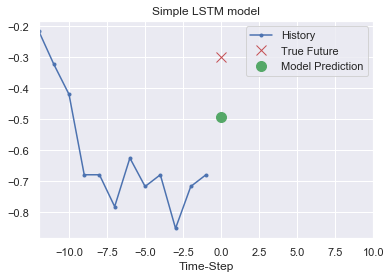

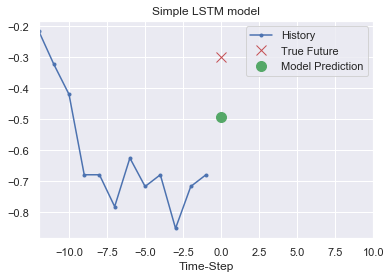

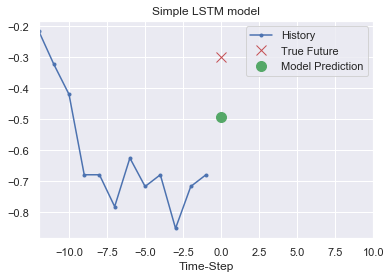

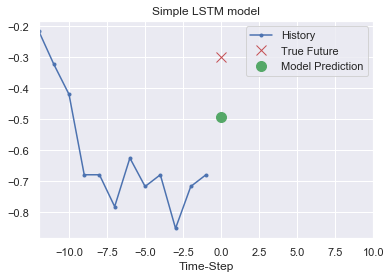

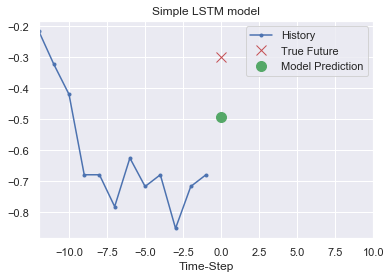

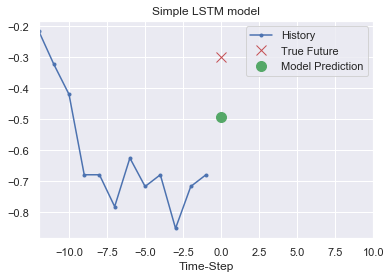

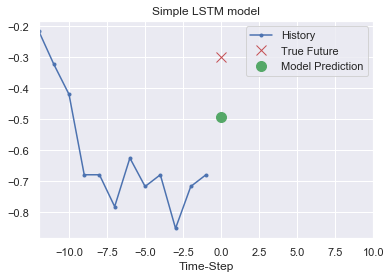

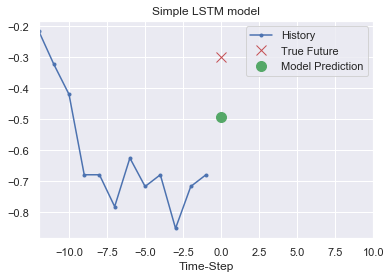

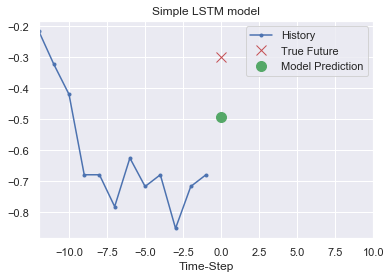

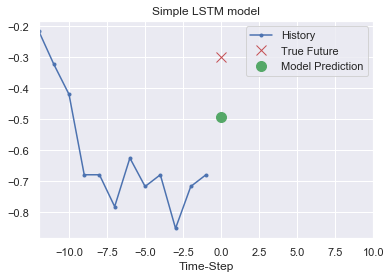

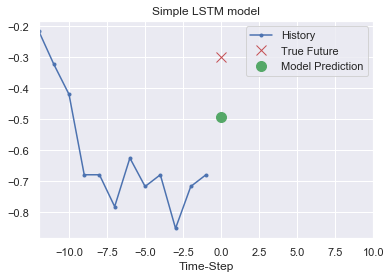

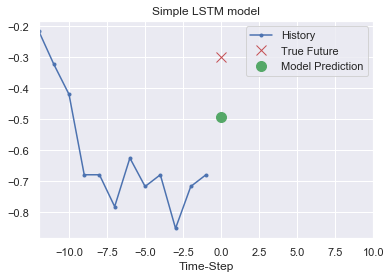

In [154]:
for x, y in val_univariate.take(12):
    plot = show_plot([x[0].numpy(), y[0].numpy(), simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
    plot.show()

power transformation

In [158]:
from scipy.stats import boxcox
# define data
data = ts
# box-cox transform
result, lmbda = boxcox(data)

In [159]:
x_train_uni3, y_train_uni3 = univariate_data(data, 0, train,
                                           ts_past_history,
                                           ts_target)
x_val_uni3, y_val_uni3 = univariate_data(data, train, None,
                                       ts_past_history,
                                       ts_target)

In [160]:
train_univariate3 = tf.data.Dataset.from_tensor_slices((x_train_uni2, y_train_uni2))
train_univariate3 = train_univariate3.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate3 = tf.data.Dataset.from_tensor_slices((x_val_uni2, y_val_uni2))
val_univariate3 = val_univariate3.batch(BATCH_SIZE).repeat()

In [161]:
%%timeit
model_simple_rnn.fit(x_train_uni3, y_train_uni3,  batch_size=12, epochs=200, verbose=0)

8.07 s ± 110 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [168]:
model_simple_rnn.fit(train_univariate3, epochs=200,
                      steps_per_epoch=12,
                      validation_data=val_univariate3, validation_steps=12)

Epoch 1/200
12/12 [==============================] - 0s 7ms/step - loss: 0.0146 - accuracy: 0.0000e+00 - mse: 0.0146 - val_loss: 0.0090 - val_accuracy: 0.0000e+00 - val_mse: 0.0090
Epoch 2/200
12/12 [==============================] - 0s 5ms/step - loss: 0.0146 - accuracy: 0.0000e+00 - mse: 0.0146 - val_loss: 0.0090 - val_accuracy: 0.0000e+00 - val_mse: 0.0090
Epoch 3/200
12/12 [==============================] - 0s 5ms/step - loss: 0.0146 - accuracy: 0.0000e+00 - mse: 0.0146 - val_loss: 0.0090 - val_accuracy: 0.0000e+00 - val_mse: 0.0090
Epoch 4/200
12/12 [==============================] - 0s 9ms/step - loss: 0.0145 - accuracy: 0.0000e+00 - mse: 0.0145 - val_loss: 0.0090 - val_accuracy: 0.0000e+00 - val_mse: 0.0090
Epoch 5/200
12/12 [==============================] - 0s 5ms/step - loss: 0.0145 - accuracy: 0.0000e+00 - mse: 0.0145 - val_loss: 0.0090 - val_accuracy: 0.0000e+00 - val_mse: 0.0090
Epoch 6/200
12/12 [==============================] - 0s 5ms/step - loss: 0.0145 - accuracy: 0.0

12/12 [==============================] - 0s 4ms/step - loss: 0.0140 - accuracy: 0.0000e+00 - mse: 0.0140 - val_loss: 0.0091 - val_accuracy: 0.0000e+00 - val_mse: 0.0091
Epoch 47/200
12/12 [==============================] - 0s 5ms/step - loss: 0.0139 - accuracy: 0.0000e+00 - mse: 0.0139 - val_loss: 0.0091 - val_accuracy: 0.0000e+00 - val_mse: 0.0091
Epoch 48/200
12/12 [==============================] - 0s 4ms/step - loss: 0.0139 - accuracy: 0.0000e+00 - mse: 0.0139 - val_loss: 0.0091 - val_accuracy: 0.0000e+00 - val_mse: 0.0091
Epoch 49/200
12/12 [==============================] - 0s 4ms/step - loss: 0.0139 - accuracy: 0.0000e+00 - mse: 0.0139 - val_loss: 0.0091 - val_accuracy: 0.0000e+00 - val_mse: 0.0091
Epoch 50/200
12/12 [==============================] - 0s 4ms/step - loss: 0.0139 - accuracy: 0.0000e+00 - mse: 0.0139 - val_loss: 0.0091 - val_accuracy: 0.0000e+00 - val_mse: 0.0091
Epoch 51/200
12/12 [==============================] - 0s 4ms/step - loss: 0.0139 - accuracy: 0.0000e+00

12/12 [==============================] - 0s 4ms/step - loss: 0.0134 - accuracy: 0.0000e+00 - mse: 0.0134 - val_loss: 0.0091 - val_accuracy: 0.0000e+00 - val_mse: 0.0091
Epoch 92/200
12/12 [==============================] - 0s 4ms/step - loss: 0.0134 - accuracy: 0.0000e+00 - mse: 0.0134 - val_loss: 0.0091 - val_accuracy: 0.0000e+00 - val_mse: 0.0091
Epoch 93/200
12/12 [==============================] - 0s 4ms/step - loss: 0.0134 - accuracy: 0.0000e+00 - mse: 0.0134 - val_loss: 0.0091 - val_accuracy: 0.0000e+00 - val_mse: 0.0091
Epoch 94/200
12/12 [==============================] - 0s 4ms/step - loss: 0.0134 - accuracy: 0.0000e+00 - mse: 0.0134 - val_loss: 0.0091 - val_accuracy: 0.0000e+00 - val_mse: 0.0091
Epoch 95/200
12/12 [==============================] - 0s 4ms/step - loss: 0.0134 - accuracy: 0.0000e+00 - mse: 0.0134 - val_loss: 0.0091 - val_accuracy: 0.0000e+00 - val_mse: 0.0091
Epoch 96/200
12/12 [==============================] - 0s 4ms/step - loss: 0.0134 - accuracy: 0.0000e+00

Epoch 136/200
12/12 [==============================] - 0s 4ms/step - loss: 0.0130 - accuracy: 0.0000e+00 - mse: 0.0130 - val_loss: 0.0089 - val_accuracy: 0.0000e+00 - val_mse: 0.0089
Epoch 137/200
12/12 [==============================] - 0s 4ms/step - loss: 0.0130 - accuracy: 0.0000e+00 - mse: 0.0130 - val_loss: 0.0089 - val_accuracy: 0.0000e+00 - val_mse: 0.0089
Epoch 138/200
12/12 [==============================] - 0s 4ms/step - loss: 0.0130 - accuracy: 0.0000e+00 - mse: 0.0130 - val_loss: 0.0089 - val_accuracy: 0.0000e+00 - val_mse: 0.0089
Epoch 139/200
12/12 [==============================] - 0s 4ms/step - loss: 0.0130 - accuracy: 0.0000e+00 - mse: 0.0130 - val_loss: 0.0089 - val_accuracy: 0.0000e+00 - val_mse: 0.0089
Epoch 140/200
12/12 [==============================] - 0s 4ms/step - loss: 0.0130 - accuracy: 0.0000e+00 - mse: 0.0130 - val_loss: 0.0089 - val_accuracy: 0.0000e+00 - val_mse: 0.0089
Epoch 141/200
12/12 [==============================] - 0s 4ms/step - loss: 0.0130 - a

Epoch 181/200
12/12 [==============================] - 0s 4ms/step - loss: 0.0126 - accuracy: 0.0000e+00 - mse: 0.0126 - val_loss: 0.0087 - val_accuracy: 0.0000e+00 - val_mse: 0.0087
Epoch 182/200
12/12 [==============================] - 0s 4ms/step - loss: 0.0126 - accuracy: 0.0000e+00 - mse: 0.0126 - val_loss: 0.0087 - val_accuracy: 0.0000e+00 - val_mse: 0.0087
Epoch 183/200
12/12 [==============================] - 0s 4ms/step - loss: 0.0126 - accuracy: 0.0000e+00 - mse: 0.0126 - val_loss: 0.0087 - val_accuracy: 0.0000e+00 - val_mse: 0.0087
Epoch 184/200
12/12 [==============================] - 0s 4ms/step - loss: 0.0126 - accuracy: 0.0000e+00 - mse: 0.0126 - val_loss: 0.0087 - val_accuracy: 0.0000e+00 - val_mse: 0.0087
Epoch 185/200
12/12 [==============================] - 0s 4ms/step - loss: 0.0126 - accuracy: 0.0000e+00 - mse: 0.0126 - val_loss: 0.0087 - val_accuracy: 0.0000e+00 - val_mse: 0.0087
Epoch 186/200
12/12 [==============================] - 0s 4ms/step - loss: 0.0126 - a

ValueError: x and y must have same first dimension, but have shapes (1,) and (12, 1)

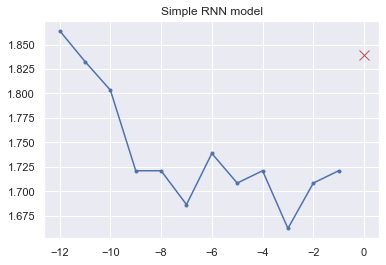

In [165]:
for x, y in val_univariate3.take(12):
    plot = show_plot([x[0].numpy(), y[0].numpy(), model_simple_rnn.predict(x)[0]], 0, 'Simple RNN model')
    plot.show()

In [171]:
simple_lstm_model.fit(train_univariate3, epochs=200,
                      steps_per_epoch=24,
                      validation_data=val_univariate3, validation_steps=50, verbose=2)

Epoch 1/200
24/24 - 0s - loss: 0.0358 - val_loss: 0.0393
Epoch 2/200
24/24 - 0s - loss: 0.0366 - val_loss: 0.0357
Epoch 3/200
24/24 - 0s - loss: 0.0364 - val_loss: 0.0366
Epoch 4/200
24/24 - 0s - loss: 0.0359 - val_loss: 0.0368
Epoch 5/200
24/24 - 0s - loss: 0.0357 - val_loss: 0.0378
Epoch 6/200
24/24 - 0s - loss: 0.0357 - val_loss: 0.0384
Epoch 7/200
24/24 - 0s - loss: 0.0358 - val_loss: 0.0386
Epoch 8/200
24/24 - 0s - loss: 0.0357 - val_loss: 0.0393
Epoch 9/200
24/24 - 0s - loss: 0.0357 - val_loss: 0.0375
Epoch 10/200
24/24 - 0s - loss: 0.0358 - val_loss: 0.0398
Epoch 11/200
24/24 - 0s - loss: 0.0367 - val_loss: 0.0383
Epoch 12/200
24/24 - 0s - loss: 0.0357 - val_loss: 0.0395
Epoch 13/200
24/24 - 0s - loss: 0.0357 - val_loss: 0.0399
Epoch 14/200
24/24 - 0s - loss: 0.0358 - val_loss: 0.0385
Epoch 15/200
24/24 - 0s - loss: 0.0357 - val_loss: 0.0388
Epoch 16/200
24/24 - 0s - loss: 0.0357 - val_loss: 0.0384
Epoch 17/200
24/24 - 0s - loss: 0.0356 - val_loss: 0.0394
Epoch 18/200
24/24 - 0s

Epoch 142/200
24/24 - 0s - loss: 0.0347 - val_loss: 0.0401
Epoch 143/200
24/24 - 0s - loss: 0.0345 - val_loss: 0.0429
Epoch 144/200
24/24 - 0s - loss: 0.0346 - val_loss: 0.0398
Epoch 145/200
24/24 - 0s - loss: 0.0342 - val_loss: 0.0403
Epoch 146/200
24/24 - 0s - loss: 0.0343 - val_loss: 0.0391
Epoch 147/200
24/24 - 0s - loss: 0.0352 - val_loss: 0.0434
Epoch 148/200
24/24 - 0s - loss: 0.0346 - val_loss: 0.0415
Epoch 149/200
24/24 - 0s - loss: 0.0346 - val_loss: 0.0411
Epoch 150/200
24/24 - 0s - loss: 0.0346 - val_loss: 0.0389
Epoch 151/200
24/24 - 0s - loss: 0.0343 - val_loss: 0.0412
Epoch 152/200
24/24 - 0s - loss: 0.0346 - val_loss: 0.0405
Epoch 153/200
24/24 - 0s - loss: 0.0342 - val_loss: 0.0420
Epoch 154/200
24/24 - 0s - loss: 0.0346 - val_loss: 0.0389
Epoch 155/200
24/24 - 0s - loss: 0.0344 - val_loss: 0.0417
Epoch 156/200
24/24 - 0s - loss: 0.0342 - val_loss: 0.0401
Epoch 157/200
24/24 - 0s - loss: 0.0353 - val_loss: 0.0391
Epoch 158/200
24/24 - 0s - loss: 0.0348 - val_loss: 0.04

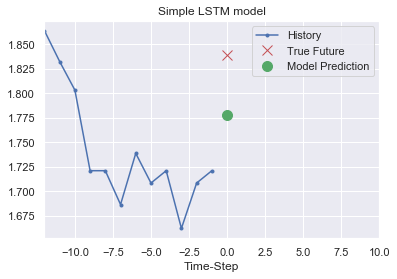

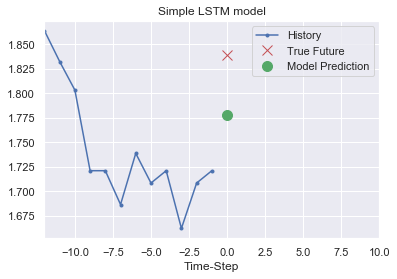

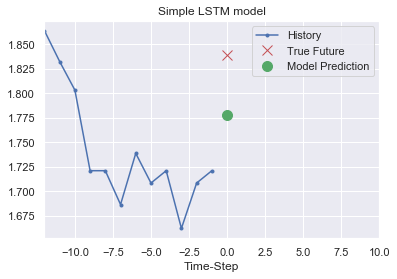

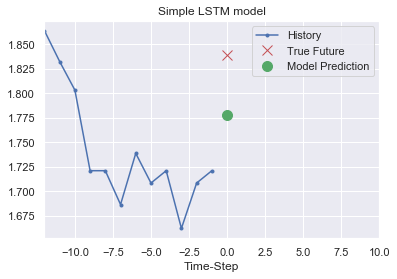

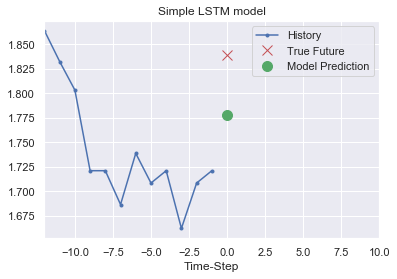

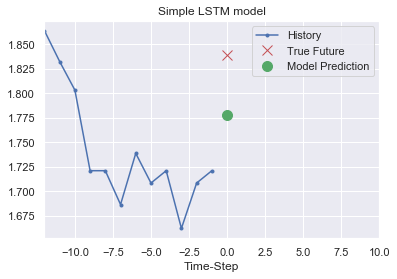

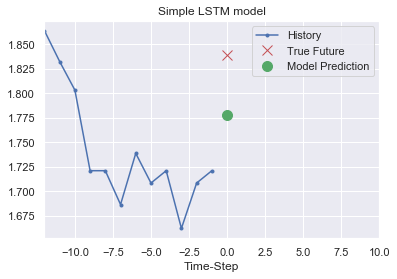

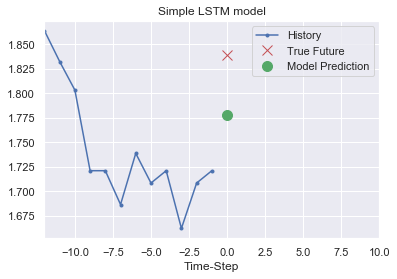

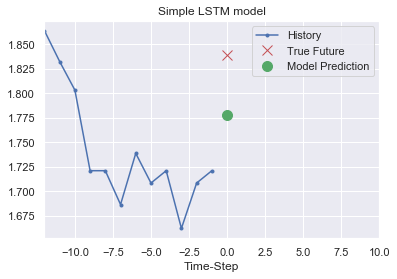

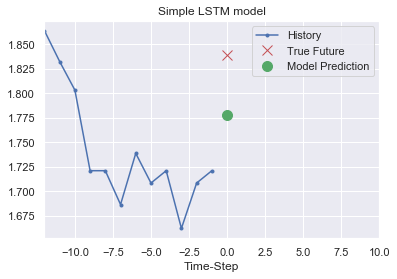

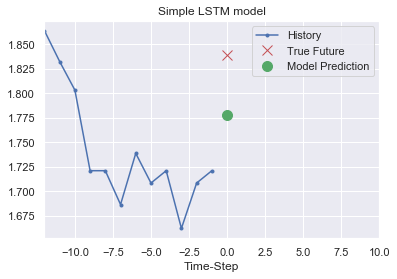

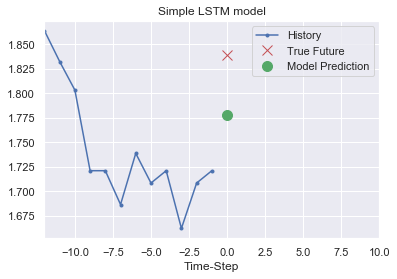

In [170]:
for x, y in val_univariate3.take(12):
    plot = show_plot([x[0].numpy(), y[0].numpy(), simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
    plot.show()